### Chain using LangGraph

##### In this section we will see how we can build a simple chain using langgraph that uses 4 important concepts

- How to use chat messages as our graph state
- How to use chat models in graph nodes
- How to bind tools to our LLM in chat models
- How to execute the tools call in our graph Nodes

In [1]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

### How to use chat messages as our graph State

### Messages

We can use messages which can be used to capture different roles within a conversation. LanChain has various message types including HumanMessage,AIMessage,SystemMessage and ToolMessage. These represent a messagfe from the user,from chatmodel, for the chat model to instruct behaviour and from a tool call.

Ever Message have these important components.

- content - content of the message
- name - Specify the name of the author
- response_metadata = optionally a dict of metadata(e.g., often populated by model provider for AIMessages)



In [2]:
from langchain_core.messages import HumanMessage,AIMessage
from pprint import pprint

messages = [AIMessage(content="Please tell me how can I help you?",name="LLMModel")]
messages.append(HumanMessage(content="I want to know the capital of France.",name="User"))
messages.append(AIMessage(content="The capital of France is Paris.",name="LLMModel"))
messages.append(HumanMessage(content="Can you also tell me the population of Paris?",name="User"))


for message in messages:
    message.pretty_print()

# here we can also use the `pprint` function to print the messages in a more readable format
# here we are appending a new message to the list of messages but we can use the reducer function to append

================================== Ai Message ==================================
Name: LLMModel

Please tell me how can I help you?
================================ Human Message =================================
Name: User

I want to know the capital of France.
================================== Ai Message ==================================
Name: LLMModel

The capital of France is Paris.
================================ Human Message =================================
Name: User

Can you also tell me the population of Paris?


### ChatModels

#### We can use the sequence of message as input with the chatmodels using LLM's and OPENAI

In [3]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="llama-3.1-8b-instant")
result = llm.invoke(messages)

# from langchain.chat_models import init_chat_model

# llm = init_chat_model(model="groq:llama-3.1-8b-instant")
# llm.invoke(messages)

In [4]:
result.response_metadata

{'token_usage': {'completion_tokens': 87,
  'prompt_tokens': 85,
  'total_tokens': 172,
  'completion_time': 0.211232907,
  'completion_tokens_details': None,
  'prompt_time': 0.004874476,
  'prompt_tokens_details': None,
  'queue_time': 0.044987794,
  'total_time': 0.216107383},
 'model_name': 'llama-3.1-8b-instant',
 'system_fingerprint': 'fp_4387d3edbb',
 'service_tier': 'on_demand',
 'finish_reason': 'stop',
 'logprobs': None,
 'model_provider': 'groq'}

### Tools

Tools can be integrated with the LLM Models to interact with external systems. External Systems can be API's, third party tools.

Whenever a query is asked the model can choose to call the tool and this query is based on the natural language input and this will return an output that matches the tool's schema

In [13]:
def add(a:int, b:int) -> int:
    """Returns the sum of a and b.

    Args:
        a: First int
        b: Second int

    Returns:
        int: Sum of a and b
    """
    return a + b

In [14]:
### Binding Tool With LLM

llm_with_tools = llm.bind_tools([add])

In [ ]:
tool_call=llm_with_tools.invoke([HumanMessage(content="What is 2 + 2?",name="Sai")])

# llm is not taking response from llm model. hers it is calling our func add() will be invoked. That is the power of tools

In [ ]:
tool_call.tool_calls 

# here it is calling our function to return the value

[{'name': 'add',
  'args': {'a': 2, 'b': 2},
  'id': 'brsnnyx9h',
  'type': 'tool_call'}]

In [40]:
## Using Messages as State

from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict

class State(TypedDict):
    messages: list[AnyMessage]

### Reducers

- 1. Now We have a Minor Problem
- 2. Each Mode will Return a new value for our state key messages
- 3. But This new value will override the prior messages value
- 4. As our graph runs, we want to append messages to our messages statekey
- 5. We can use reducer functions to address this.
- 6. reducers allow us to specify how state updates are performed
- 7. If No reducer function is specified, then it is assumed that updates to the key should override it as a we saw before.
- 8. But to append messages, we can use the pre-built add_messages reducer
- 9. This Ensures that any messages are appended to the existing list of messages.
- 10. We simply need to annotate our messages key with add_messages reducer function as metatdata

In [41]:
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [42]:
### reducers with add_messages

intial_messages = [AIMessage(content="Please tell me how can I help you?",name="LLMModel")]
intial_messages.append(HumanMessage(content="I want to know the capital of France.",name="User"))
intial_messages

[AIMessage(content='Please tell me how can I help you?', additional_kwargs={}, response_metadata={}, name='LLMModel', tool_calls=[], invalid_tool_calls=[]),
 HumanMessage(content='I want to know the capital of France.', additional_kwargs={}, response_metadata={}, name='User')]

In [43]:
ai_message = AIMessage(content="The capital of France is Paris.",name="LLMModel")

add_messages(intial_messages, ai_message)

### reducers is to append instead of overwrite the messages list. so we can use add_messages reducer to append the new message to the list of messages

[AIMessage(content='Please tell me how can I help you?', additional_kwargs={}, response_metadata={}, name='LLMModel', id='b14335d1-40a1-4be6-a999-1ad003473c71', tool_calls=[], invalid_tool_calls=[]),
 HumanMessage(content='I want to know the capital of France.', additional_kwargs={}, response_metadata={}, name='User', id='0570e2ad-2ebe-42f4-8cda-4e6721284909'),
 AIMessage(content='The capital of France is Paris.', additional_kwargs={}, response_metadata={}, name='LLMModel', id='bef10964-4eeb-49d0-9b43-3b1df6426cab', tool_calls=[], invalid_tool_calls=[])]

In [44]:
## Chatbot Node Functionality
def llm_tool(state:State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


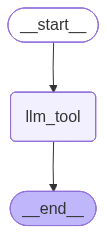

In [45]:
## Defining our state Graph

from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END

builder = StateGraph(State)
builder.add_node("llm_tool", llm_tool)
builder.add_edge(START, "llm_tool")
builder.add_edge("llm_tool", END)


graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [46]:
### Invocation of the graph

messages = graph.invoke({"messages": "What is 2+2?"})


for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 2+2?
================================== Ai Message ==================================
Tool Calls:
  add (axvc1gkkd)
 Call ID: axvc1gkkd
  Args:
    a: 2
    b: 2


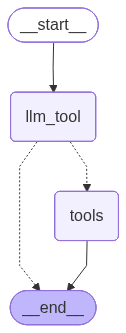

In [48]:
### Question is where exavtly llm is calling the tool?
### Ans: We will add now

tools = [add]

# In langgraph we can add tool_node

from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


builder = StateGraph(State)
builder.add_node("llm_tool",llm_tool)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"llm_tool")
builder.add_conditional_edges("llm_tool",tools_condition)

builder.add_edge("tools",END)

graph_builder = builder.compile()

display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [49]:
messages = graph_builder.invoke({"messages": "What is 2+2?"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 2+2?
================================== Ai Message ==================================
Tool Calls:
  add (jyd8x5pda)
 Call ID: jyd8x5pda
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: add

4
